# Piotruś i Wilk: Wprowadzenie do Uczenia ze Wzmocnieniem

W tym tutorialu nauczymy się, jak zastosować uczenie ze wzmocnieniem do problemu znajdowania ścieżek. Scenariusz jest inspirowany muzyczną bajką [Piotruś i Wilk](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) rosyjskiego kompozytora [Siergieja Prokofiewa](https://en.wikipedia.org/wiki/Sergei_Prokofiev). To opowieść o młodym pionierze Piotrusiu, który odważnie wychodzi z domu na polanę w lesie, aby ścigać wilka. Wytrenujemy algorytmy uczenia maszynowego, które pomogą Piotrusiowi eksplorować otaczający teren i stworzyć optymalną mapę nawigacyjną.

Najpierw zaimportujmy kilka przydatnych bibliotek:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Przegląd uczenia przez wzmacnianie

**Uczenie przez wzmacnianie** (RL) to technika uczenia, która pozwala nam nauczyć się optymalnego zachowania **agenta** w określonym **środowisku** poprzez przeprowadzanie wielu eksperymentów. Agent w tym środowisku powinien mieć określony **cel**, zdefiniowany przez **funkcję nagrody**.

## Środowisko

Dla uproszczenia, rozważmy świat Piotra jako kwadratową planszę o wymiarach `width` x `height`. Każde pole na tej planszy może być:
* **ziemią**, po której Piotr i inne stworzenia mogą chodzić
* **wodą**, po której oczywiście nie można chodzić
* **drzewem** lub **trawą** - miejscem, gdzie można odpocząć
* **jabłkiem**, które symbolizuje coś, co Piotr chętnie znajdzie, aby się posilić
* **wilkiem**, który jest niebezpieczny i należy go unikać

Aby pracować ze środowiskiem, zdefiniujemy klasę o nazwie `Board`. Aby nie zaśmiecać tego notatnika, cały kod związany z obsługą planszy przenieśliśmy do osobnego modułu `rlboard`, który teraz zaimportujemy. Możesz zajrzeć do tego modułu, aby uzyskać więcej szczegółów na temat implementacji.


In [2]:
from rlboard import *

Stwórzmy teraz losową planszę i zobaczmy, jak wygląda:


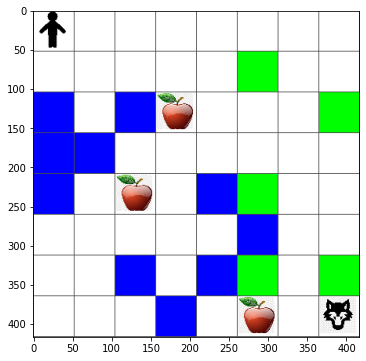

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Akcje i Polityka

W naszym przykładzie celem Piotra jest znalezienie jabłka, jednocześnie unikając wilka i innych przeszkód. Aby to osiągnąć, może po prostu chodzić, aż znajdzie jabłko. Dlatego na każdej pozycji może wybrać jedną z następujących akcji: w górę, w dół, w lewo i w prawo. Zdefiniujemy te akcje jako słownik i przypiszemy je do par odpowiadających zmian współrzędnych. Na przykład, ruch w prawo (`R`) odpowiadałby parze `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategia naszego agenta (Piotra) jest określana za pomocą tak zwanej **polityki**. Rozważmy najprostszą politykę, zwaną **losowym spacerem**.

## Losowy spacer

Najpierw rozwiążmy nasz problem, implementując strategię losowego spaceru.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Uruchommy eksperyment losowego spaceru kilka razy i zobaczmy średnią liczbę wykonanych kroków:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Funkcja nagrody

Aby nasza polityka była bardziej inteligentna, musimy zrozumieć, które ruchy są "lepsze" od innych.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Zbuduj Q-Table, czyli wielowymiarową tablicę. Ponieważ nasza plansza ma wymiary `width` x `height`, możemy reprezentować Q-Table jako tablicę numpy o kształcie `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Przekaż tabelę Q do funkcji wykresu, aby zwizualizować tabelę na planszy:


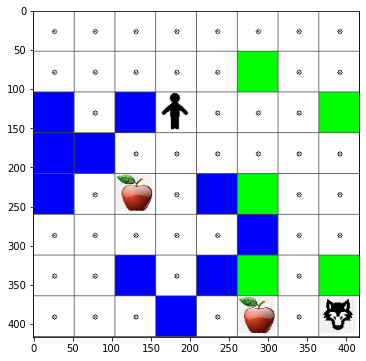

In [9]:
m.plot(Q)

## Istota Q-Learning: Równanie Bellmana i Algorytm Uczenia

Napisz pseudokod dla naszego algorytmu uczenia:

* Zainicjalizuj Q-Tablicę Q równymi wartościami dla wszystkich stanów i akcji
* Ustaw współczynnik uczenia $\alpha\leftarrow 1$
* Powtarzaj symulację wiele razy
   1. Rozpocznij w losowej pozycji
   1. Powtarzaj
        1. Wybierz akcję $a$ w stanie $s$
        2. Wykonaj akcję, przechodząc do nowego stanu $s'$
        3. Jeśli napotkamy warunek końca gry lub całkowita nagroda jest zbyt mała - zakończ symulację  
        4. Oblicz nagrodę $r$ w nowym stanie
        5. Zaktualizuj funkcję Q zgodnie z równaniem Bellmana: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Zaktualizuj całkowitą nagrodę i zmniejsz $\alpha$.

## Eksploatacja vs. Eksploracja

Najlepszym podejściem jest znalezienie równowagi między eksploracją a eksploatacją. W miarę jak coraz lepiej poznajemy nasze środowisko, będziemy bardziej skłonni podążać optymalną trasą, jednak warto od czasu do czasu wybrać nieodkrytą ścieżkę.

## Implementacja w Pythonie

Teraz jesteśmy gotowi zaimplementować algorytm uczenia. Zanim to zrobimy, potrzebujemy również funkcji, która przekształci dowolne liczby w Q-Tablicy w wektor prawdopodobieństw dla odpowiadających akcji:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Dodajemy niewielką wartość `eps` do oryginalnego wektora, aby uniknąć dzielenia przez 0 w początkowym przypadku, gdy wszystkie składniki wektora są identyczne.

Rzeczywisty algorytm uczenia, który przeprowadzimy przez 5000 eksperymentów, nazywanych również **epokami**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Po wykonaniu tego algorytmu, tabela Q powinna zostać zaktualizowana wartościami określającymi atrakcyjność różnych działań na każdym kroku. Zwizualizuj tabelę tutaj:


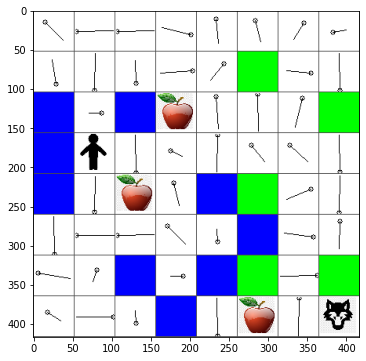

In [12]:
m.plot(Q)

## Sprawdzanie Polityki

Ponieważ Q-Table przedstawia "atrakcyjność" każdej akcji w każdym stanie, bardzo łatwo jest użyć go do określenia efektywnej nawigacji w naszym świecie. W najprostszym przypadku możemy po prostu wybrać akcję odpowiadającą najwyższej wartości w Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Jeśli spróbujesz powyższego kodu kilka razy, możesz zauważyć, że czasami po prostu "zawiesza się" i musisz nacisnąć przycisk STOP w notebooku, aby go przerwać.

> **Zadanie 1:** Zmodyfikuj funkcję `walk`, aby ograniczyć maksymalną długość ścieżki do określonej liczby kroków (np. 100), i obserwuj, jak powyższy kod zwraca tę wartość od czasu do czasu.

> **Zadanie 2:** Zmodyfikuj funkcję `walk`, aby nie wracała do miejsc, w których już wcześniej była. To zapobiegnie zapętleniu `walk`, jednak agent nadal może utknąć w miejscu, z którego nie będzie w stanie się wydostać.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


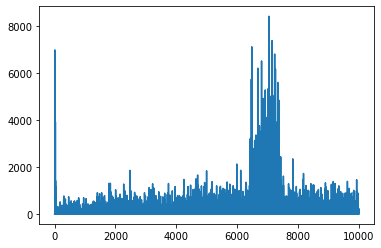

In [15]:
plt.plot(lpath)

To, co tutaj widzimy, to początkowy wzrost średniej długości ścieżki. Prawdopodobnie wynika to z faktu, że gdy nic nie wiemy o środowisku, łatwo wpaść w złe stany, takie jak woda czy wilk. Gdy zdobywamy więcej wiedzy i zaczynamy ją wykorzystywać, możemy eksplorować środowisko dłużej, ale wciąż nie wiemy dokładnie, gdzie znajdują się jabłka.

Kiedy nauczymy się wystarczająco dużo, agentowi łatwiej jest osiągnąć cel, a długość ścieżki zaczyna się zmniejszać. Jednak wciąż jesteśmy otwarci na eksplorację, więc często odbiegamy od najlepszej ścieżki i testujemy nowe opcje, co sprawia, że ścieżka jest dłuższa niż optymalna.

Na tym wykresie zauważamy również, że w pewnym momencie długość ścieżki gwałtownie wzrosła. Wskazuje to na stochastyczny charakter procesu oraz na to, że w pewnym momencie możemy "zepsuć" współczynniki w Q-Table, nadpisując je nowymi wartościami. Idealnie powinno się to minimalizować poprzez zmniejszenie współczynnika uczenia (np. pod koniec treningu dostosowujemy wartości w Q-Table tylko o niewielkie wartości).

Ogólnie rzecz biorąc, ważne jest, aby pamiętać, że sukces i jakość procesu uczenia się w dużym stopniu zależą od parametrów, takich jak współczynnik uczenia, jego zmniejszanie oraz współczynnik dyskontowania. Często nazywa się je **hiperparametrami**, aby odróżnić je od **parametrów**, które optymalizujemy podczas treningu (np. współczynniki w Q-Table). Proces znajdowania najlepszych wartości hiperparametrów nazywa się **optymalizacją hiperparametrów** i zasługuje na osobny temat.


## Ćwiczenie
#### Bardziej realistyczny świat Piotrusia i wilka

W naszej sytuacji Piotruś mógł poruszać się niemal bez zmęczenia czy głodu. W bardziej realistycznym świecie musi od czasu do czasu usiąść i odpocząć, a także się posilić. Uczyńmy nasz świat bardziej realistycznym, wprowadzając następujące zasady:

1. Przemieszczając się z jednego miejsca do drugiego, Piotruś traci **energię** i zyskuje trochę **zmęczenia**.
2. Piotruś może odzyskać energię, jedząc jabłka.
3. Piotruś może pozbyć się zmęczenia, odpoczywając pod drzewem lub na trawie (czyli wchodząc na pole planszy z drzewem lub trawą - zielone pole).
4. Piotruś musi znaleźć i zabić wilka.
5. Aby zabić wilka, Piotruś musi mieć odpowiedni poziom energii i zmęczenia, w przeciwnym razie przegra walkę.

Zmodyfikuj funkcję nagrody zgodnie z zasadami gry, uruchom algorytm uczenia ze wzmocnieniem, aby nauczyć się najlepszej strategii wygrania gry, i porównaj wyniki losowego spaceru z wynikami swojego algorytmu pod względem liczby wygranych i przegranych gier.

> **Note**: Może być konieczne dostosowanie hiperparametrów, aby wszystko działało, szczególnie liczby epok. Ponieważ sukces gry (walka z wilkiem) jest rzadkim zdarzeniem, możesz spodziewać się znacznie dłuższego czasu treningu.



---

**Zastrzeżenie**:  
Ten dokument został przetłumaczony za pomocą usługi tłumaczenia AI [Co-op Translator](https://github.com/Azure/co-op-translator). Chociaż dokładamy wszelkich starań, aby tłumaczenie było precyzyjne, prosimy pamiętać, że automatyczne tłumaczenia mogą zawierać błędy lub nieścisłości. Oryginalny dokument w jego rodzimym języku powinien być uznawany za wiarygodne źródło. W przypadku informacji o kluczowym znaczeniu zaleca się skorzystanie z profesjonalnego tłumaczenia przez człowieka. Nie ponosimy odpowiedzialności za jakiekolwiek nieporozumienia lub błędne interpretacje wynikające z użycia tego tłumaczenia.
